<center>
    <img src="./img/nike.jpg" alt="Nike">
</center>

### NIKE

Hoy vamos a presentar el análisis que hemos realizado para predecir las 
ventas de unas zapatillas de Nike utilizando técnicas de Machine Learning. 
Nuestro objetivo principal ha sido identificar los factores clave que influyen en las 
ventas y preparar el dataset para la implementación de modelos predictivos.
Para ello, trabajamos con un dataset que contiene información detallada de
ventas en diferentes regiones y períodos de tiempo. Este dataset cuenta con 1000 
registros y 10 variables, y nuestra variable objetivo es Revenue_USD, que 
representa los ingresos generados por las ventas de zapatillas en distintas 
condiciones.

### Importacion de librerias

In [26]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from math import sqrt
from scipy.stats import f_oneway, kruskal
from scipy.stats import chi2_contingency, f_oneway


### Objetivo del Trabajo:

El objetivo principal de este trabajo es predecir las ventas de zapatillas en función de diversas variables. En este caso, la variable objetivo elegida es RevenueUSD, ya que es una medida directa de las ventas (en dólares) y facilita la predicción.

Descripción del Dataset:

El dataset contiene las siguientes columnas:

* Variables categóricas: mes, región, categoría, subcategoría, producto de línea, porcentaje vendido online.
* Variables numéricas: precio, unidades vendidas, ventas en dólares (RevenueUSD).

In [5]:
df = pd.read_csv("./data/nike_sales_2024.csv")
df

Month         Region Main_Category Sub_Category       Product_Line  \
0    November          India     Equipment         Bags           Gym Sack   
1     January          India     Equipment  Accessories               Hats   
2     October          India       Apparel         Tops        Tech Fleece   
3    December  Greater China      Footwear      Cricket      Vapor Cricket   
4         May  Greater China     Equipment        Socks  Performance Socks   
..        ...            ...           ...          ...                ...   
995   October          India     Equipment  Accessories               Hats   
996      July         Europe     Equipment        Socks  Performance Socks   
997    August          Japan      Footwear     Football     Phantom Vision   
998       May    South Korea     Equipment        Socks         Crew Socks   
999  December          Japan      Footwear      Cricket      Vapor Cricket   

    Price_Tier  Units_Sold  Revenue_USD  Online_Sales_Percentage  Retail_Price  
0       Budget       48356     14506800                       73           300  
1       Budget        9842      2066820                       50           210  
2    Mid-Range       25079      1755530                       90            70  
3      Premium       41404      8694840                       58           210  
4      Premium       33569      5371040                       53           160  
..         ...         ...          ...                      ...           ...  
995  Mid-Range        9870       987000                       82           100  
996  Mid-Range       14668      2640240                       88           180  
997    Premium       15078      2261700                       74           150  
998    Premium       26242      1312100                       52            50  
999  Mid-Range       18133      5077240                       68           280  

[1000 rows x 10 columns]

Procedemos a la observacion y limpieza del dataset

In [6]:
#Reviso Nulos
nulos_nike = df.isnull().sum()
print("Nulos por columna:")
print(nulos_nike)

Nulos por columna:
Month                      0
Region                     0
Main_Category              0
Sub_Category               0
Product_Line               0
Price_Tier                 0
Units_Sold                 0
Revenue_USD                0
Online_Sales_Percentage    0
Retail_Price               0
dtype: int64


In [7]:
#Reviso Duplicados
duplicados_nike = df.duplicated().sum()
print(f"Filas duplicadas: {duplicados_nike}")

Filas duplicadas: 0


In [8]:
#Reviso los tipos
print(df.dtypes)


Month                      object
Region                     object
Main_Category              object
Sub_Category               object
Product_Line               object
Price_Tier                 object
Units_Sold                  int64
Revenue_USD                 int64
Online_Sales_Percentage     int64
Retail_Price                int64
dtype: object


In [9]:
# Reviso que no hayan palabras que se escriban diferente y que tengan el mismo valor
for col in ['Region', 'Main_Category', 'Sub_Category', 'Price_Tier', "Product_Line"]:
    print(f"Valores únicos en {col}:")
    print(df[col].unique())



Valores únicos en Region:
['India' 'Greater China' 'Japan' 'Europe' 'South Korea' 'America'
 'Southeast Asia']
Valores únicos en Main_Category:
['Equipment' 'Apparel' 'Footwear']
Valores únicos en Sub_Category:
['Bags' 'Accessories' 'Tops' 'Cricket' 'Socks' 'Performance' 'Outerwear'
 'Lifestyle' 'Running' 'Basketball' 'Football']
Valores únicos en Price_Tier:
['Budget' 'Mid-Range' 'Premium']
Valores únicos en Product_Line:
['Gym Sack' 'Hats' 'Tech Fleece' 'Vapor Cricket' 'Performance Socks'
 'Dri-FIT' 'Therma-FIT' 'Bags' 'Crew Socks' 'Backpack' 'Rain Jacket'
 'Air Force 1' 'React Infinity' 'Windrunner' 'Air Jordan'
 'Compression Wear' 'Air Zoom' 'Mercurial' 'Air Max' 'KD Series'
 'LeBron Series' 'Phantom Vision' 'Blazer' 'Pegasus']


Despues de aseguramos que no hubiera valores nulos y verificar la consistencia de los 
datos. hemos creado  una función que nos permitiera clasificar 
automáticamente las variables según su tipo, diferenciando entre variables 
numéricas continuas y discretas, así como variables categóricas.

In [22]:
def describe_df(df):
    """
    Vamos a generar un resumen detallado de nuestro dataframe

    Los argumentos serán:
    1--> El DataFrame seleccionado que sera df_nike para analizar

    Devuelve:
    pd.DataFrame: Un Dataframe con la información global resumida
                 - Tipo de dato de cada columna
                  - Porcentaje de valores nulos
                  - Cantidad de valores únicos
                  - Porcentaje de cardinalidad
                  - Valores mínimo y máximo (para columnas numéricas)
                  - Moda (valor más frecuente en cada columna)
    """
    
# Paso 1: Tipo de dato de cada columna
    # Usaremos "df.dtypes" ya que devuelve los tipos de datos de cada columna...
    tipos_de_dato = df.dtypes 
    
# Paso 2: Calcular el porcentaje de valores nulos
    # Usaremos "df.isnull()"" que nos devuelve un DataFrame de valores booleanos donde True nos dice que es un valor nulo
    # Usaremos "mean()" para calcular el promedio de estos nulos por columna
    # Multiplicaremos por 100 para obtener el porcentaje y redondeamos a 2 decimales
    porcentaje_nulos = (df.isnull().mean() * 100).round(2)
    
# Paso 3: Contar los valores únicos por columna
    # Usaremos "df.nunique()"" para contar la cantidad de valores únicos en cada columna
    valores_unicos = df.nunique()  
    
# Paso 4: Calcular el porcentaje de cardinalidad
    # Dividimos los valores únicos entre el total y luego multiplicamos por 100 para obtener el porcentaje
    porcentaje_cardinalidad = ((valores_unicos / len(df)) * 100).round(2)
    
    
# Paso 5: Calcular valores mínimo y máximo para columnas numéricas
    # Usaremos "df.select_dtypes(include='number')" para selecciona solo las columnas numéricas
    # Usaremos "min()" y "max()" para calcular los valores mínimo y máximo
    minimos = df.select_dtypes(include='number').min()
    maximos = df.select_dtypes(include='number').max()
    
# Paso 6: Calcular la moda 
    # Usaremos "df.mode()" que nos devolverá el valor más frecuente en cada columna. Si hay varias, seleccionaremos la primera con ".iloc[0]"
    moda = df.mode().iloc[0]
    
# Paso 8: Construir el resumen
    # Crearemos un diccionario
    resumen = {
        "Tipo de dato": tipos_de_dato,
        "% Nulos": porcentaje_nulos,
        "Valores únicos": valores_unicos,
        "% Cardinalidad": porcentaje_cardinalidad,
        "Valor mínimo": minimos,
        "Valor máximo": maximos,
        "Moda": moda
    }
    
# Paso 9 Convertiremos el diccionario en un DataFrame 
    resumen_df = pd.DataFrame(resumen)
    
# Paso 10: Retornaremos
    return resumen_df


In [23]:
descripcion = describe_df(df)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)     
print(descripcion)

                        Tipo de dato  % Nulos  Valores únicos  % Cardinalidad  Valor mínimo  Valor máximo           Moda
Main_Category                 object      0.0               3             0.3           NaN           NaN      Equipment
Month                         object      0.0              12             1.2           NaN           NaN       December
Online_Sales_Percentage        int64      0.0              41             4.1          50.0          90.0           73.0
Price_Tier                    object      0.0               3             0.3           NaN           NaN         Budget
Product_Line                  object      0.0              24             2.4           NaN           NaN     Windrunner
Region                        object      0.0               7             0.7           NaN           NaN  Greater China
Retail_Price                   int64      0.0              26             2.6          50.0         300.0          290.0
Revenue_USD                    i

In [19]:
def tipifica_variables(df, umbral_categoria, umbral_continua):
    """
    Esta funcion no dara el tipo de variable para cada columna de nuestro dataframe

    Argumentos:
    DataFrame: Evaluaremos  las variables
    umbral_categoria (int): Umbral para definir si una variable es categórica
    umbral_continua (float): Porcentaje mínimo de cardinalidad para definir si una variable es continua

    Retorna:
    DataFrame: Dos columnas una con el nombre de la variable y el otro con el tipo de variable, que contiene el nombre de cada variable y su tipo sugerido (Binaria, Categórica, Numérica Continua,"Numérica Discreta).
    """

# Paso 1 Creanis una lista donde se guardarán los resultados
    resultados = []

    # Paso 2.1 Itineramos por cada columna del DataFrame de entrada
    for col in df.columns:
        # Paso 6 Verificamos si la columna contiene valores categóricos basados en su tipo de dato como puede ser object
        if df[col].dtype == 'object' or isinstance(df[col].iloc[0], str):
            tipo = "Categórica"
        # Paso 2.2 Calculamos la cardinalidad: el número de valores únicos de la columna
        else:
            valores_unicos = df[col].nunique()
         # Paso 2.3 Calculamos el porcentaje de cardinalidad
            porcentaje_cardinalidad = valores_unicos / len(df)

        # Paso 2.4 Clasificamos las columnas segun las reglas dadas por el guion del trabajo
            if valores_unicos == 2:  
                tipo = "Binaria"
            elif valores_unicos < umbral_categoria:  # Si la cardinalidad es menor al umbral
                tipo = "Categórica"
            else:  # Si la cardinalidad es mayor o igual al umbral
                if porcentaje_cardinalidad >= umbral_continua:
                    tipo = "Numérica Continua"  # Si el porcentaje de cardinalidad es mayor o igual al umbral continuo
                else:
                    tipo = "Numérica Discreta"  # Caso contrario, es discreta

        # Paso 2.5 Añadimos el resultado como un diccionario con el nombre de la columna y su tipo sugerido
        resultados.append({"nombre_variable": col, "tipo_sugerido": tipo})

    # Paso 3 Convertimos la lista de resultados en un DF
    resultado_df_nike = pd.DataFrame(resultados)

    # Paso 4 Devolvemos el DF
    return resultado_df_nike


In [20]:
#Paso 5 Llamamos a la funcion y le pasomos 3 argumentos, 1 DF, 2 umbral categoria (Si tiene menos de 4 valores únicos es categorica), 3 umbral continua (0.5--> 50% de las filas tienen valores únicos) si el % es menor es discreta.
resultado = tipifica_variables(df, umbral_categoria=4, umbral_continua=0.5)
print(resultado)


           nombre_variable      tipo_sugerido
0                    Month         Categórica
1                   Region         Categórica
2            Main_Category         Categórica
3             Sub_Category         Categórica
4             Product_Line         Categórica
5               Price_Tier         Categórica
6               Units_Sold  Numérica Continua
7              Revenue_USD  Numérica Continua
8  Online_Sales_Percentage  Numérica Discreta
9             Retail_Price  Numérica Discreta


Después de esta etapa de limpieza y preparación, el siguiente pao es 
analizar qué variables tienen mayor relación con la variable objetivo, es decir, 
cuáles son los factores más relevantes que influyan en los ingresos de ventas de 
zapatillas. Para ello, utilizamos diferentes métodos estadísticos, dividiendo el 
análisis en dos partes: una para variables numéricas y otra para variables 
categóricas.

### Análisis para datos numéricos

Para analizar la relación entre las variables numéricas y la variable 
objetivo, utilizamos una función que calcula la correlación entre ellas. El objetivo 
era determinar qué variables numéricas tenían la mayor influencia en los ingresos.

In [1]:
target_col=['Revenue_USD']

In [2]:
def get_features_num_regression(df, target_col, umbral_corr=0.3, pvalue=None):
    """
    Devuelve una lista con las columnas numéricas del DataFrame cuya correlación absoluta con target_col 
    sea superior a umbral_corr. Si pvalue no es None, también se filtran por significación estadística.
    Si los argumentos de entrada no son adecuados, devuelve None e imprime la razón.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        target_col (str): Columna del DataFrame que será utilizada como target (debe ser numérica continua).
        umbral_corr (float): Umbral de correlación absoluta (0 a 1).
        pvalue (float, optional): Nivel de significancia para filtrar (1 - pvalue).

    Returns:
        list or None: Lista de columnas numéricas que cumplen los criterios, o None si los argumentos son inválidos.
    """
    # Comprobación 1: Que el DataFrame sea válido
    if not isinstance(df, pd.DataFrame):
        print("Error: El argumento 'df' debe ser un DataFrame de pandas.")
        return None

    # Comprobación 2: Que target_col exista y sea numérica continua
    if target_col not in df.columns:
        print(f"Error: La columna target '{target_col}' no está en el DataFrame.")
        return None
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f"Error: La columna target '{target_col}' no es numérica.")
        return None
    if len(df[target_col].unique()) <= 10:  # Suponemos que <10 valores únicos no es continuo
        print(f"Error: La columna target '{target_col}' no parece ser continua (tiene pocos valores únicos).")
        return None

    # Comprobación 3: Que umbral_corr sea un float entre 0 y 1
    if not isinstance(umbral_corr, (float, int)) or not (0 <= umbral_corr <= 1):
        print("Error: El argumento 'umbral_corr' debe ser un número entre 0 y 1.")
        return None

    # Comprobación 4: Que pvalue sea None o un float válido
    if pvalue is not None and (not isinstance(pvalue, (float, int)) or not (0 < pvalue <= 1)):
        print("Error: El argumento 'pvalue' debe ser None o un número entre 0 y 1.")
        return None

    # Seleccionar columnas numéricas excluyendo el target
    columnas_numericas = df.select_dtypes(include='number').columns
    columnas_numericas = [col for col in columnas_numericas if col != target_col]

    if len(columnas_numericas) == 0:
        print("Error: No hay columnas numéricas (excluyendo la target) en el DataFrame.")
        return None

    # Lista para almacenar las columnas que cumplen los criterios
    columnas_seleccionadas = []

    # Calcular correlaciones y valores p
    for col in columnas_numericas:
        correlacion, p_val = pearsonr(df[col], df[target_col])

        # Filtrar por correlación
        if abs(correlacion) > umbral_corr:
            # Filtrar por p-value si se proporciona
            if pvalue is None or p_val <= pvalue:
                columnas_seleccionadas.append(col)

    # Si no se encuentran columnas que cumplan los criterios, devolver None
    if not columnas_seleccionadas:
        print("No se encontraron columnas que cumplan con los criterios especificados.")
        return None

    return columnas_seleccionadas

In [21]:
# Llamo a la función
resultado = get_features_num_regression(
    df= df,           
    target_col="Revenue_USD",    
    umbral_corr=0.5,             
    pvalue=0.05                 
)

print(resultado)

['Units_Sold', 'Retail_Price']


La correlación mide el grado de relación entre dos variables. En este caso, 
usamos el coeficiente de correlación de Pearson para evaluar qué variables 
numéricas estaban más relacionadas con Revenue_USD. Como resultado, 
identificamos que las dos variables con mayor correlación fueron:
1. Units_Sold (Unidades Vendidas): Con un coeficiente de correlación de 0.69, esta 
fue la variable más influyente. La relación es clara: cuantas más unidades se 
venden, mayor es el ingreso.
2. Retail_Price (Precio de Venta): Con una correlación de 0.66, el precio de venta 
también afecta significativamente los ingresos, aunque de manera no 
completamente lineal. A medida que aumenta el precio, los ingresos tienden a 
subir, pero con mayor dispersión en los valores más altos

In [27]:
def plot_features_num_regression(df, target_col, selected_features):
    """
    Lo que hace esta función es generar gráficas para ver la relación entre las features y la variable objetivo

    Argumentos:
    - df_nike (pd.DataFrame): DataFrame de entrada de los datos
    - target_col (str): Nombre de la columna objetivo (tiene que ser numérica).
    - selected_features (list): Lista de variables seleccionadas para hacer el modelo de regresión.

    Returns:
    - Devuelve gráficas de dispersión entre cada variable seleccionada y la variable target
    """
    # Hago las validaciones oportunas
    if not isinstance(df, pd.DataFrame):
        raise ValueError("El argumento 'df_nike' debe ser un DataFrame")
    
    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' no está en el DataFrame")
    
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        raise ValueError(f" '{target_col}' no es numérica")
    
    if not selected_features or not isinstance(selected_features, list):
        raise ValueError("El argumento 'selected_features' debe ser una lista de variables")
    
    # Filtro las variables seleccionadas del DataFrame
    selected_features = [col for col in selected_features if col in df.columns]
    
    if len(selected_features) == 0: 
        raise ValueError("No hay variables seleccionadas en el DataFrame")

    for feature in selected_features:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df[feature], y=df[target_col], alpha=0.7,color="#f55e13")
        plt.title(f"Relación entre {feature} y {target_col}")
        plt.xlabel(feature)
        plt.ylabel(target_col)
        plt.grid(True)
        plt.show()

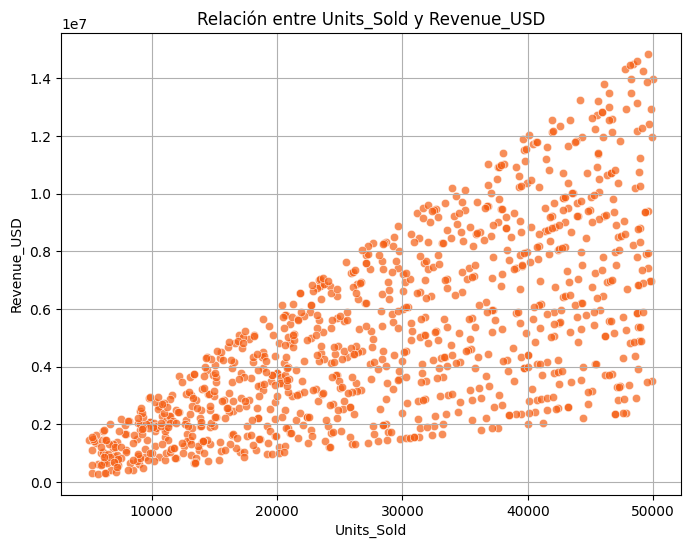

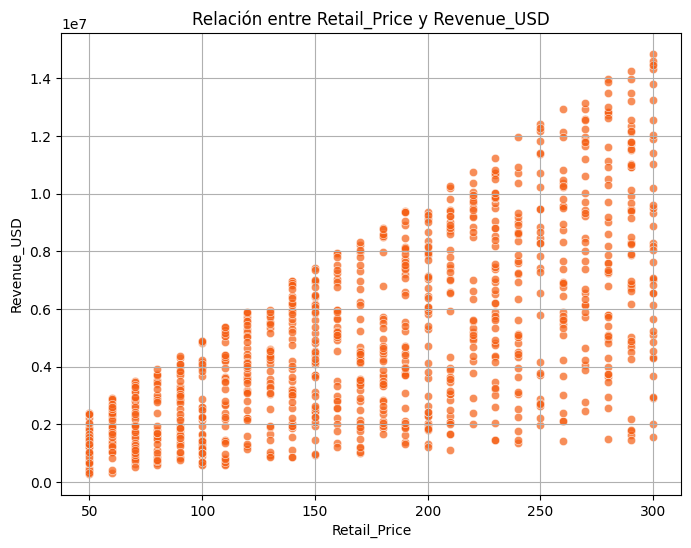

In [28]:
selected_features = ["Units_Sold", "Retail_Price"]
plot_features_num_regression(df, target_col="Revenue_USD", selected_features=selected_features)

Para visualizar estas relaciones, generamos gráficos de dispersión 
(scatterplots). En ellos, observamos que los datos se distribuyen en una diagonal 
ascendente, lo que confirma la fuerte relación entre unidades vendidas e ingresos. 
También notamos que, aunque el precio de venta influye, hay más variabilidad en 
los ingresos cuando los precios son altos, lo que sugiere que otros factores pueden 
estar interviniendo.

### Análisis categórico

En el caso de las variables categóricas, el enfoque es distinto. No 
podíamos utilizar el coeficiente de Pearson porque este solo se aplica a variables 
numéricas continuas. Las variables categóricas, al estar compuestas por diferentes
grupos o categorías, requieren otro tipo de análisis estadístico.

* Para determinar si las variables categóricas afectaban significativamente 
los ingresos, utilizamos dos pruebas estadísticas:

1. ANOVA (Análisis de Varianza): Se emplea cuando la variable 
categórica tiene más de dos grupos y la variable dependiente (en este caso, 
Revenue_USD) es numérica. Nos permite comparar las medias de los diferentes 
grupos y ver si hay diferencias significativas entre ellos.

3. Kruskal-Wallis: Es una alternativa a ANOVA que se usa cuando 
los datos no siguen una distribución normal. Lo elegimos para asegurarnos de que 
las diferencias en ingresos entre las distintas categorías fueran estadísticamente 
significativas sin asumir normalidad en los datos.

Tras aplicar estas pruebas, identificamos que la variable Sub_Category 
tenía una relación significativa con los ingresos. Esto significa que ciertos tipos de 
zapatillas generan más ingresos que otros. 

In [ ]:
def get_features_cat_regression(df, target_col, pvalue=0.05):
    """
    Devuelve una lista con las columnas categóricas del DataFrame cuyo test de relación con la columna
    designada por 'target_col' sea estadísticamente significativa usando ANOVA o Kruskal-Wallis.
    Argumentos:
    df: DataFrame para analizar.
    target_col (str): Columna objetivo (numérica).
    pvalue (float): Nivel de significancia para el test. Por defecto es 0.05.
    Retorna:
    list: Una lista con las columnas categóricas del DataFrame que tienen una relación significativa
          con la columna objetivo.
    """
    # Comprobar que la columna objetivo existe y es numérica
    if target_col not in df.columns:
        raise ValueError(f"La columna '{target_col}' no existe en el DataFrame.")
    if target_col not in df.select_dtypes(include=[np.number]).columns:
        raise ValueError(f"La columna '{target_col}' no es numérica en el DataFrame.")
    # Seleccionar columnas categóricas
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    # Lista para almacenar las columnas categóricas relevantes
    relevant_cat_columns = []
    # Iterar sobre las columnas categóricas
    for column in cat_columns:
        # Excluir columnas con demasiados valores nulos
        if df[column].isnull().mean() > 0.5:  # Umbral de 50% de valores nulos
            continue
        # Excluir columnas con una sola categoría
        if df[column].nunique() <= 1:
            continue
        # Agrupar los valores de la columna objetivo por las categorías
        groups = [df[df[column] == value][target_col].dropna() for value in df[column].unique()]
        # Si hay categorías sin datos en la columna objetivo, ignorar la columna
        if any(len(group) == 0 for group in groups):
            continue
        # Elegir la prueba estadística (ANOVA o Kruskal-Wallis)
        try:
            if all(len(group) >= 5 for group in groups):  # Suficientes datos para ANOVA
                stat, p_value = f_oneway(*groups)
            else:  # Usar Kruskal-Wallis si hay pocos datos o distribución no normal
                stat, p_value = kruskal(*groups)
        except ValueError:
            continue  # Saltar si ocurre algún error en las pruebas
        # Verificar si el p-value cumple con el umbral especificado
        if p_value <= pvalue:
            relevant_cat_columns.append(column)
    return relevant_cat_columns

In [33]:
def plot_features_cat_regression(df, target_col="", columns=[], pvalue=0.05, with_individual_plot=False):
    """
    Genera histogramas agrupados para las columnas categóricas relacionadas con 'target_col'.
    
    Args:
        df (pd.DataFrame): DataFrame con los datos.
        target_col (str): Columna objetivo, debe ser numérica.
        columns (list): Lista de columnas categóricas a considerar (opcional).
        pvalue (float): Nivel de significancia estadística (por defecto 0.05).
        with_individual_plot (bool): Si True, genera gráficos individuales por categoría (por defecto False).
        
    Returns:
        list or None: Lista de columnas que cumplen con el criterio de relación estadística o None si hay errores.
    """
    # Validaciones iniciales
    if not isinstance(df, pd.DataFrame):
        print("Error: 'df' debe ser un DataFrame de pandas.")
        return None
    if target_col not in df.columns:
        print(f"Error: La columna objetivo '{target_col}' no está en el DataFrame.")
        return None
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f"Error: La columna objetivo '{target_col}' no es numérica.")
        return None
    if len(df[target_col].unique()) <= 10:
        print(f"Error: La columna objetivo '{target_col}' no tiene suficiente cardinalidad (debe ser continua).")
        return None
    if not isinstance(columns, list):
        print("Error: 'columns' debe ser una lista.")
        return None
    if not isinstance(pvalue, (float, int)) or not (0 < pvalue <= 1):
        print("Error: 'pvalue' debe ser un número entre 0 y 1.")
        return None

    # Si la lista 'columns' está vacía, selecciona todas las columnas categóricas
    if not columns:
        columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Lista para las columnas que cumplen los criterios estadísticos
    columnas_seleccionadas = []

    # Evaluar las relaciones estadísticas
    for col in columns:
        # Validar que la columna categórica no tenga demasiadas categorías únicas
        if df[col].nunique() < 2:
            print(f"Advertencia: La columna '{col}' tiene menos de 2 categorías. Se omitirá.")
            continue
        if df[col].nunique() > 50:
            print(f"Advertencia: La columna '{col}' tiene más de 50 categorías. Se omitirá.")
            continue

        # Realizar el test adecuado
        try:
            if df[col].nunique() <= 10:  # Para variables categóricas con pocas categorías, usar Chi-cuadrado
                contingency_table = pd.crosstab(df[col], df[target_col])
                _, p_val, _, _ = chi2_contingency(contingency_table)
            else:  # Para variables categóricas con muchas categorías, usar ANOVA
                groups = [df[df[col] == category][target_col] for category in df[col].unique()]
                _, p_val = f_oneway(*groups)

            # Verificar si el p-value es menor o igual al umbral
            if p_val <= pvalue:
                columnas_seleccionadas.append(col)

                # Generar el histograma agrupado
                if not with_individual_plot:
                    sns.histplot(data=df, x=target_col, hue=col, kde=True, element="step")
                    plt.title(f"Distribución de {target_col} agrupada por {col}")
                    plt.show()
                else:
                    # Gráficos individuales para cada categoría
                    unique_values = df[col].unique()
                    for val in unique_values:
                        sns.histplot(data=df[df[col] == val], x=target_col, kde=True)
                        plt.title(f"Distribución de {target_col} para {col} = {val}")
                        plt.show()

        except Exception as e:
            print(f"Error al procesar la columna '{col}': {e}")
            continue

    # Si no se encontraron columnas que cumplan los criterios
    if not columnas_seleccionadas:
        print("No se encontraron columnas categóricas que cumplan con los criterios especificados.")
        return None

    return columnas_seleccionadas


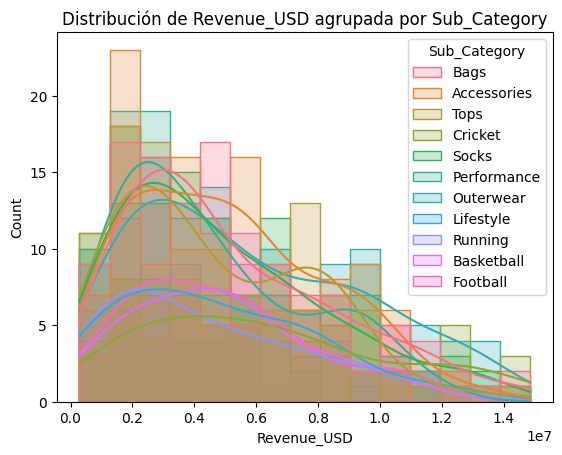

Columnas categóricas relacionadas con el target: ['Sub_Category']


In [34]:
# Llamar a la función con tus datos
categorical_columns = plot_features_cat_regression(
    df=df, 
    target_col="Revenue_USD",  # Cambia al nombre exacto de tu columna objetivo
    columns=[],  # Puedes dejarlo vacío para usar todas las columnas categóricas
    pvalue=0.05,  # Nivel de significancia estadística
    with_individual_plot=False  # Cambia a True si quieres gráficos individuales por categoría
)

# Ver las columnas seleccionadas
print("Columnas categóricas relacionadas con el target:", categorical_columns)

Para visualizar esta información, 
construimos un histograma donde observamos que las subcategorías accesories y bags 
presentan los picos más altos en ventas. Esto sugiere que estos productos tienen 
una mayor demanda y contribuyen más a los ingresos totales.
En conclusión, nuestro análisis confirmó que tanto las variables numéricas 
como las categóricas influyen en las ventas, pero de manera diferente. Las unidades vendidas y el precio de venta son los factores numéricos más 
importantes, mientras que dentro de las categorías de productos, algunos modelos 
específicos tienen un impacto significativamente mayor en los ingresos

### Conclusiones generales

A partir de este análisis, podemos extraer varias conclusiones clave sobre
los factores que influyen en las ventas de zapatillas Nike:

1. Las unidades vendidas son el factor más determinante en los ingresos, con 
una correlación de 0.69. Esto indica que la cantidad de productos vendidos es el 
mejor predictor de las ventas totales.
2. El precio de venta también es un factor relevante, con una correlación de 
0.66. Sin embargo, su relación con los ingresos no es completamente lineal, ya que
en los precios más altos se observa una mayor dispersión.
3. Las subcategorías de productos influyen significativamente en los ingresos.
Algunas, como Bag y Accesoriess, tienen picos de ventas más altos que otras, lo que 
indica que ciertos modelos generan más ingresos.
4. El canal de ventas online representa el 73% de las ventas, lo que lo 
convierte en un factor clave a considerar en futuras estrategias comerciales.


### Mejoras del modelo

Con estos resultados, el siguiente paso es mejorar la precisión del modelo 
predictivo y optimizar su implementación. Para ello, proponemos:

1. Incorporar la subcategoría de productos en el modelo para mejorar la 
precisión de las predicciones.

2. Probar diferentes algoritmos de Machine Learning, como regresión lineal, 
árboles de decisión y redes neuronales, para comparar su desempeño y elegir el 
más eficiente.

3. Analizar la estacionalidad de las ventas para identificar patrones a lo largo 
del año y predecir fluctuaciones en la demanda.

4. Optimizar la visualización de datos, mejorando los gráficos para facilitar la 
interpretación de los resultados.

5. Realizar más pruebas estadísticas para validar hipótesis y evaluar posibles 
nuevas relaciones entre variables

En conclusión, este trabajo nos ha permitido comprender mejor los 
factores que determinan las ventas de zapatillas Nike y desarrollar una base sólida
para la predicción de ingresos utilizando Machine Learning. Con los siguientes 
pasos, podremos afinar aún más nuestro modelo y aplicarlo para tomar decisiones 